# Resultados




In [47]:
import shap
import pickle
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, fbeta_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from statistics import median

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Cargar modelos y resultados

In [48]:
with open('../app/modelos/modelos_lightgbm.pkl', 'rb') as f:
        data = pickle.load(f)

evals_result_GBEmbeddings = data['evals_result_GBEmbeddings']
evals_result_GB = data['evals_result_GB']
evals_result_GBSMOTE = data['evals_result_GBSMOTE']
evals_result_GBEmbeddingsSMOTE = data['evals_result_GBEmbeddingsSMOTE']
Z_train = data['Z_train']
Z_val = data['Z_val']
Z_test = data['Z_test']
tab_train = data['tab_train']
tab_val = data['tab_val']
tab_test = data['tab_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
best_iters_GBEmbeddings = data['best_iters_GBEmbeddings']
best_iters_GB = data['best_iters_GB']
best_iters_GBSMOTE = data['best_iters_GBSMOTE']
best_iters_GBEmbeddingsSMOTE = data['best_iters_GBEmbeddingsSMOTE']
thr_f1_GBEmbeddings = data['thr_f1_GBEmbeddings']
thr_f2_GBEmbeddings = data['thr_f2_GBEmbeddings']
thr_f05_GBEmbeddings = data['thr_f05_GBEmbeddings']
thr_f1_GB = data['thr_f1_GB']
thr_f2_GB = data['thr_f2_GB']
thr_f05_GB = data['thr_f05_GB']
thr_f1_GBSMOTE = data['thr_f1_GBSMOTE']
thr_f2_GBSMOTE = data['thr_f2_GBSMOTE']
thr_f05_GBSMOTE = data['thr_f05_GBSMOTE']
thr_f1_GBEmbeddingsSMOTE = data['thr_f1_GBEmbeddingsSMOTE']
thr_f2_GBEmbeddingsSMOTE = data['thr_f2_GBEmbeddingsSMOTE']
thr_f05_GBEmbeddingsSMOTE = data['thr_f05_GBEmbeddingsSMOTE']
num_cols = data['num_cols']

## Testear resultados finales

In [49]:
def testear_modelo(X_tr, y_train, X_va, y_val, X_te, y_test, best_iters, thr_f1, thr_f2, thr_f05):
    """Entrenamiento final y evaluación en TEST"""

    params = {
        'objective': 'binary',
        'metric': ['average_precision', 'binary_logloss'],
        'first_metric_only': True,
        'learning_rate': 0.05,
        'num_leaves': 8,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
        'min_data_in_leaf': 100,
        'seed': RANDOM_STATE,
        'num_threads': -1,
    }

    # 1) num_boost_round robusto desde la CV
    final_nrounds = int(median(best_iters))

    # 2) Entrenamiento FINAL en TRAIN+VAL (sin early stopping)
    X_tv = np.vstack([X_tr, X_va])
    y_tv = np.concatenate([y_train, y_val])
    dall = lgb.Dataset(X_tv, label=y_tv, free_raw_data=False)

    clf_final = lgb.train(
        params,
        dall,
        num_boost_round=final_nrounds
    )

    # 3) Umbrales FIJOS (desde CV)
    thr_f1_med  = float(median(thr_f1))
    thr_f2_med  = float(median(thr_f2))
    thr_f05_med = float(median(thr_f05))

    # 4) Evaluación en TEST
    t0 = time.perf_counter()
    y_prob_te = clf_final.predict(X_te, num_iteration=final_nrounds)
    t1 = time.perf_counter()
    print(f"\nTiempo de inferencia en TEST (por línea): {1e6*(t1 - t0)/X_te.shape[0]:.5f} microsegundos/línea")

    pr_auc_te = average_precision_score(y_test, y_prob_te)
    print(f"\nTEST — PR-AUC={pr_auc_te:.4f}")

    def metrics_at_threshold(y_true, y_prob, thr, beta):
        y_pred = (y_prob >= thr).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f = fbeta_score(y_true, y_pred, beta=beta, zero_division=0)
        return f, p, r, thr

    f1_te,  p1,  r1,  t1  = metrics_at_threshold(y_test, y_prob_te, thr_f1_med,  1.0)
    f2_te,  p2,  r2,  t2  = metrics_at_threshold(y_test, y_prob_te, thr_f2_med,  2.0)
    f05_te, p05, r05, t05 = metrics_at_threshold(y_test, y_prob_te, thr_f05_med, 0.5)

    print(f"TEST (umbral CV) — F1={f1_te:.4f}  (P={p1:.4f},  R={r1:.4f},  thr={t1:.4f})")
    print(f"TEST (umbral CV) — F2={f2_te:.4f}  (P={p2:.4f},  R={r2:.4f},  thr={t2:.4f})")
    print(f"TEST (umbral CV) — F0.5={f05_te:.4f} (P={p05:.4f}, R={r05:.4f}, thr={t05:.4f})")

    return clf_final, y_prob_te

#### GB + Embeddings secuenciales

In [50]:
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

clf_GBEmbeddings, y_prob_GBEmbeddings = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBEmbeddings, 
               thr_f1_GBEmbeddings, 
               thr_f2_GBEmbeddings, 
               thr_f05_GBEmbeddings)

[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

Tiempo de inferencia en TEST (por línea): 0.47329 microsegundos/línea

TEST — PR-AUC=0.4402
TEST (umbral CV) — F1=0.5417  (P=0.4643,  R=0.6500,  thr=0.1446)
TEST (umbral CV) — F2=0.5603  (P=0.3611,  R=0.6500,  thr=0.0722)
TEST (umbral CV) — F0.5=0.5435 (P=0.5556, R=0.5000, thr=0.5104)


#### GB

In [51]:
X_tr = tab_train.values
X_va = tab_val.values
X_te = tab_test.values

clf_GB, y_prob_GB = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GB, 
               thr_f1_GB, 
               thr_f2_GB, 
               thr_f05_GB)

[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

Tiempo de inferencia en TEST (por línea): 1.24324 microsegundos/línea

TEST — PR-AUC=0.3301
TEST (umbral CV) — F1=0.3200  (P=0.8000,  R=0.2000,  thr=0.5909)
TEST (umbral CV) — F2=0.3211  (P=0.2414,  R=0.3500,  thr=0.1945)
TEST (umbral CV) — F0.5=0.5556 (P=1.0000, R=0.2000, thr=0.6261)


#### GB + SMOTE

In [52]:
X_tr = tab_train.values
X_va = tab_val.values
X_te = tab_test.values

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

clf_GBSMOTE, y_prob_GBSMOTE = testear_modelo(X_tr_resampled, y_train_resampled, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBSMOTE, 
               thr_f1_GBSMOTE, 
               thr_f2_GBSMOTE, 
               thr_f05_GBSMOTE)

[LightGBM] [Info] Number of positive: 63140, number of negative: 84160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 147300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428649 -> initscore=-0.287365
[LightGBM] [Info] Start training from score -0.287365

Tiempo de inferencia en TEST (por línea): 0.75839 microsegundos/línea

TEST — PR-AUC=0.2702
TEST (umbral CV) — F1=0.2941  (P=0.3571,  R=0.2500,  thr=0.9752)
TEST (umbral CV) — F2=0.2451  (P=0.2273,  R=0.2500,  thr=0.9683)
TEST (umbral CV) — F0.5=0.0000 (P=0.0000, R=0.0000, thr=0.9858)


#### GB + Embeddings secuenciales + SMOTE

In [53]:
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

clf_GBEmbeddingsSMOTE, y_prob_GBEmbeddingsSMOTE = testear_modelo(X_tr_resampled, y_train_resampled, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBEmbeddingsSMOTE, 
               thr_f1_GBEmbeddingsSMOTE, 
               thr_f2_GBEmbeddingsSMOTE, 
               thr_f05_GBEmbeddingsSMOTE)

[LightGBM] [Info] Number of positive: 63140, number of negative: 84160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 147300, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428649 -> initscore=-0.287365
[LightGBM] [Info] Start training from score -0.287365

Tiempo de inferencia en TEST (por línea): 0.88225 microsegundos/línea

TEST — PR-AUC=0.5309
TEST (umbral CV) — F1=0.4138  (P=0.6667,  R=0.3000,  thr=0.9856)
TEST (umbral CV) — F2=0.5505  (P=0.4138,  R=0.6000,  thr=0.8238)
TEST (umbral CV) — F0.5=0.4808 (P=0.6250, R=0.2500, thr=0.9883)


## Curva precision-recall

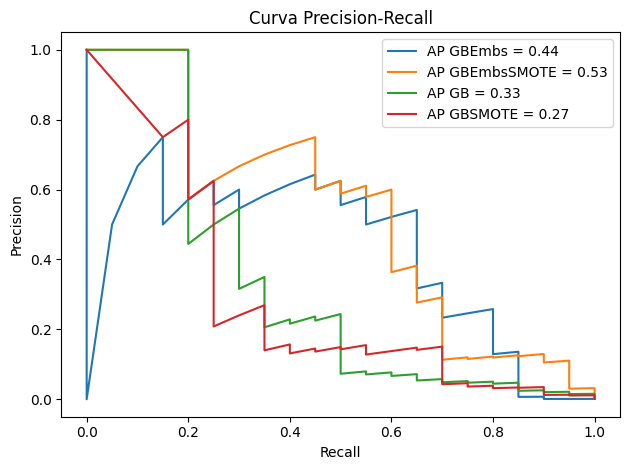

In [54]:
# Modelo con embeddings
precision_GBEmbeddings, recall_GBEmbeddings, thresholds = precision_recall_curve(y_test, y_prob_GBEmbeddings)
ap_GBEmbeddings = average_precision_score(y_test, y_prob_GBEmbeddings)

# Modelo sin embeddings
precision_GB, recall_GB, thresholds = precision_recall_curve(y_test, y_prob_GB)
ap_GB = average_precision_score(y_test, y_prob_GB)

# Moddelo con SMOTE
precision_GBSMOTE, recall_GBSMOTE, thresholds = precision_recall_curve(y_test, y_prob_GBSMOTE)
ap_GBSMOTE = average_precision_score(y_test, y_prob_GBSMOTE)

# Modelo con embeddings y SMOTE
precision_GBEmbeddingsSMOTE, recall_GBEmbeddingsSMOTE, thresholds = precision_recall_curve(y_test, y_prob_GBEmbeddingsSMOTE)
ap_GBEmbeddingsSMOTE = average_precision_score(y_test, y_prob_GBEmbeddingsSMOTE)

plt.plot(recall_GBEmbeddings, precision_GBEmbeddings, label=f"AP GBEmbs = {ap_GBEmbeddings:.2f}")
plt.plot(recall_GBEmbeddingsSMOTE, precision_GBEmbeddingsSMOTE, label=f"AP GBEmbsSMOTE = {ap_GBEmbeddingsSMOTE:.2f}")
plt.plot(recall_GB, precision_GB, label=f"AP GB = {ap_GB:.2f}")
plt.plot(recall_GBSMOTE, precision_GBSMOTE, label=f"AP GBSMOTE = {ap_GBSMOTE:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.tight_layout()
plt.savefig("../informes/figuras/precision_recall.png", dpi=180, bbox_inches="tight")
plt.show()


### Beeswarms y gráfico de barras SHAP

In [55]:
def to_2d(values):
    if isinstance(values, list):
        return values[1] if len(values) == 2 else np.mean(np.abs(np.stack(values, axis=2)), axis=2)
    return values

/home/david/miniconda3/envs/bde-fraude/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipykernel_5001/3317724980.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, show=False)
/tmp/ipykernel_5001/3317724980.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, plot_type="bar", show=False)
/tmp/ipykernel_5001/3317724980.py:41: FutureWar

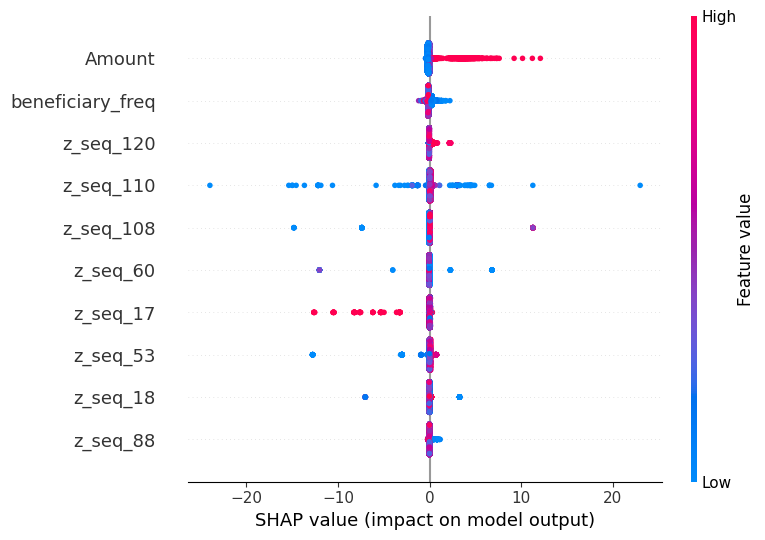

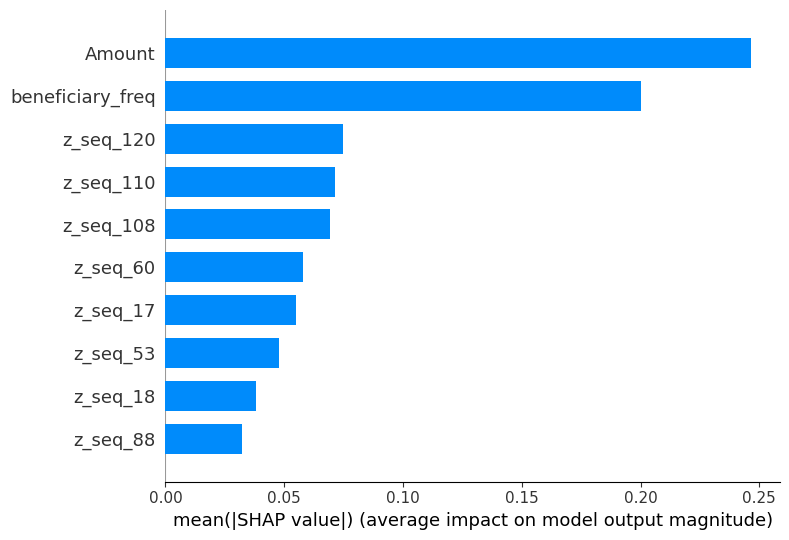

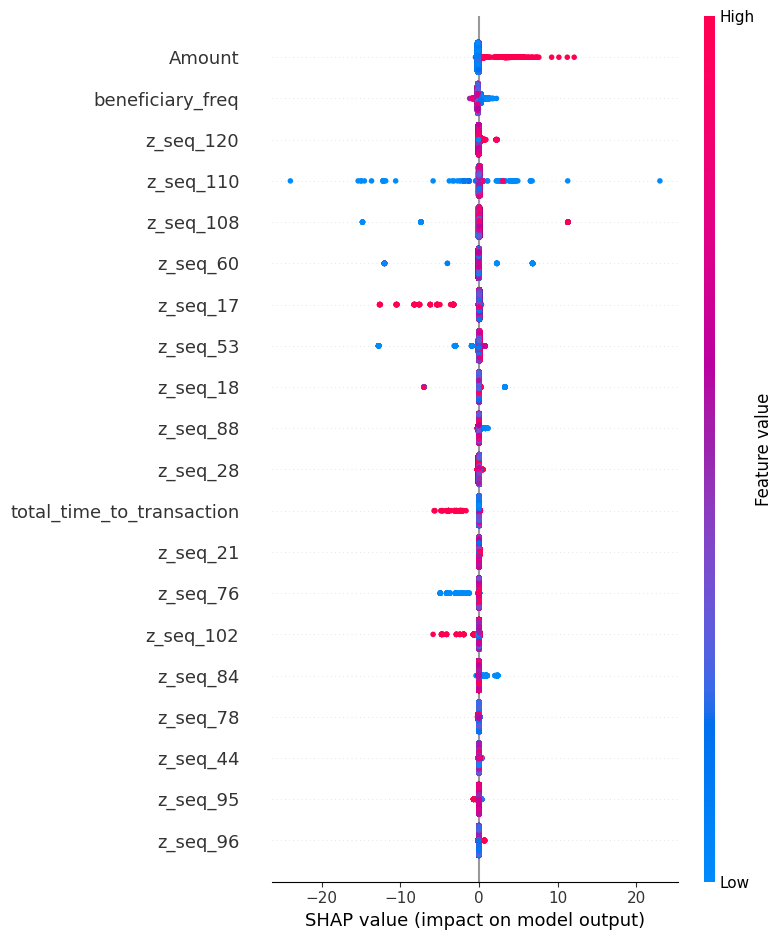

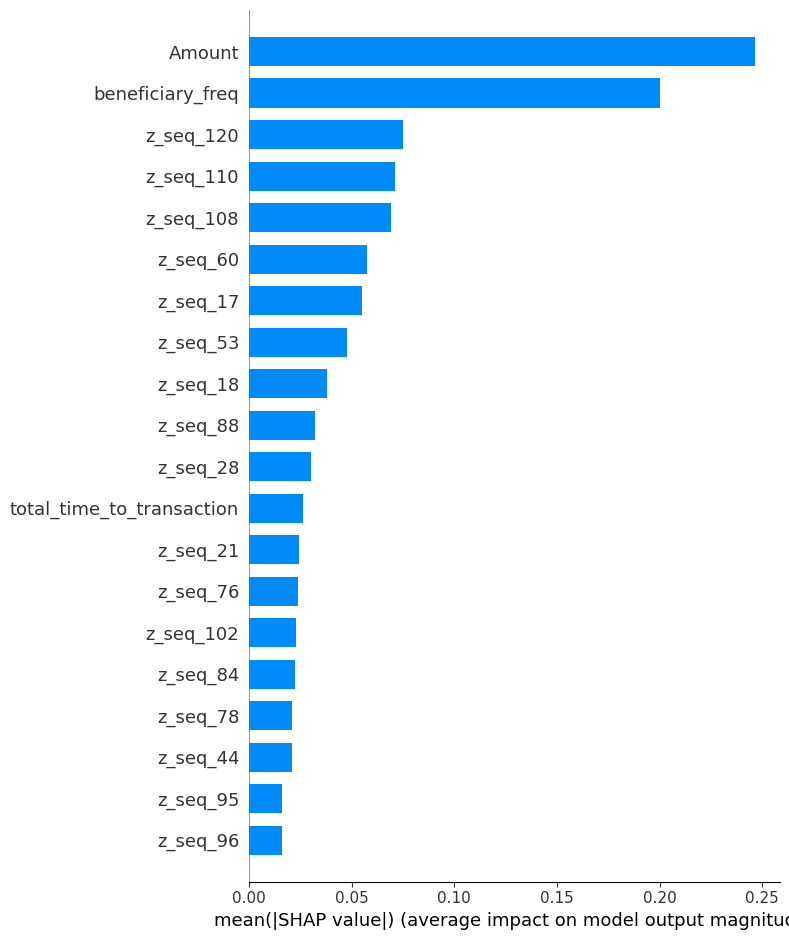

In [56]:

# Construye nombres de features
z_dim = Z_test.shape[1]
z_cols = [f"z_seq_{i}" for i in range(z_dim)]
feature_names = num_cols + z_cols

X_te = np.hstack([tab_test.values,   Z_test])

# Explainer SHAP
explainer = shap.TreeExplainer(clf_GBEmbeddings)
shap_values = explainer.shap_values(
    X_te,
    tree_limit=getattr(clf_GBEmbeddings, "best_iteration", None)
)

shap_2d = to_2d(shap_values)

# 1) Importancia media absoluta por feature
mean_abs_shap = np.abs(shap_2d).mean(axis=0)

# 2) Índices de las 10 más importantes (ordenadas de mayor a menor)
top_idx = np.argsort(mean_abs_shap)[-10:][::-1]

# 3) Filtrar valores y nombres
shap_top = shap_2d[:, top_idx]
feature_names_top = [feature_names[i] for i in top_idx]

# 4) Beeswarm solo con top-10
plt.figure()
shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEncoder_shap_summary_beeswarm_top10.png", dpi=180, bbox_inches="tight")

# Gráfico de barras solo con top-10
plt.figure()
shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEncoder_shap_importance_bar_top10.png", dpi=180, bbox_inches="tight")

# Beeswarm
plt.figure()
shap.summary_plot(shap_2d, X_te, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEncoder_shap_summary_beeswarm.png", dpi=180, bbox_inches="tight")

# Gráfico de barras
plt.figure()
shap.summary_plot(shap_2d, X_te, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEncoder_shap_importance_bar.png", dpi=180, bbox_inches="tight")


/home/david/miniconda3/envs/bde-fraude/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipykernel_5001/1946583691.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, show=False)
/tmp/ipykernel_5001/1946583691.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, plot_type="bar", show=False)
/tmp/ipykernel_5001/1946583691.py:39: FutureWar

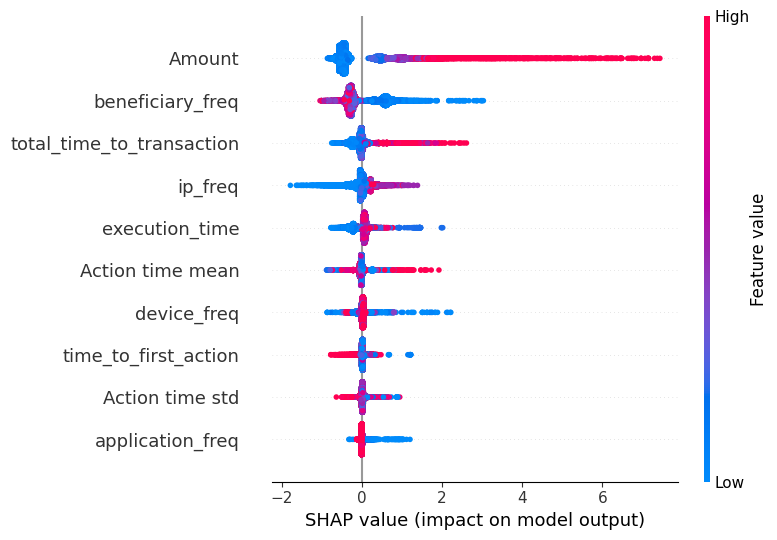

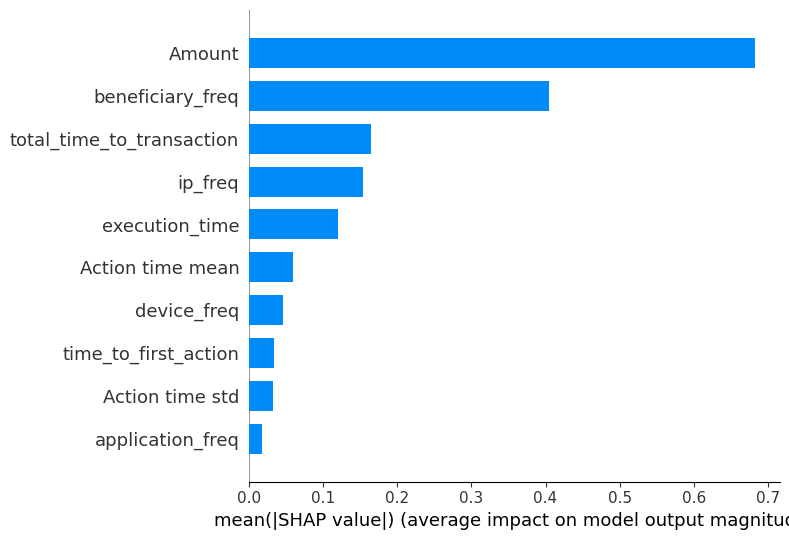

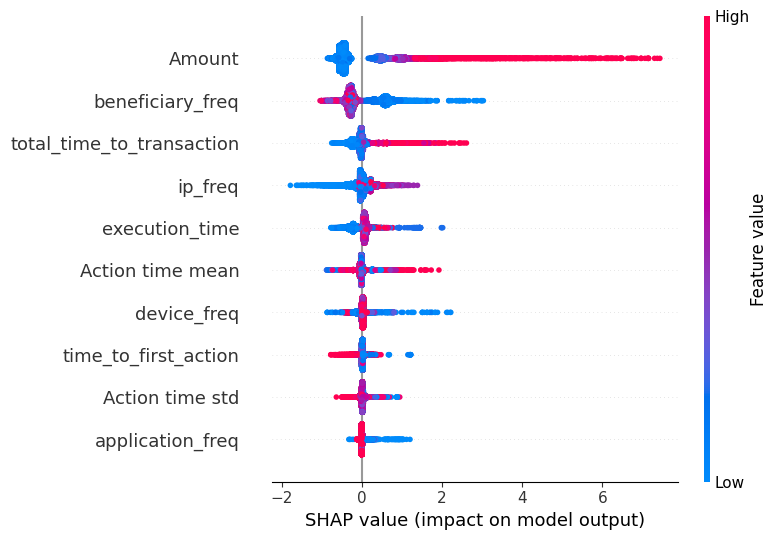

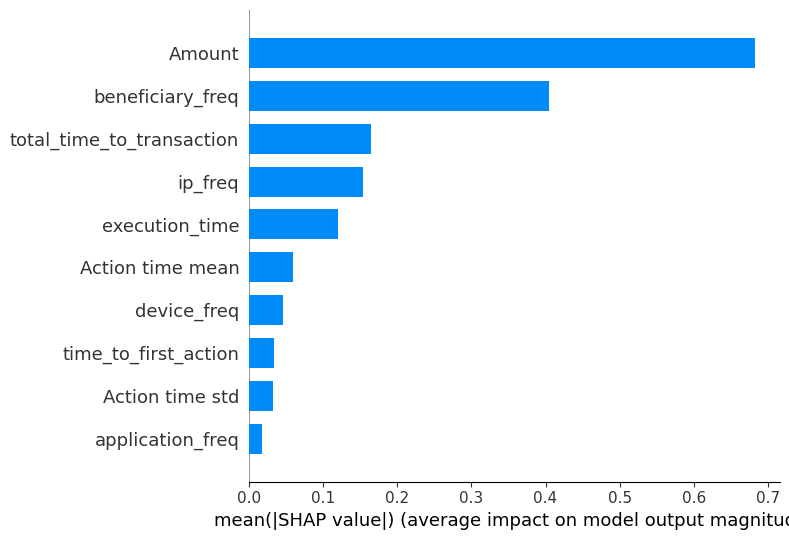

In [57]:
# Construye nombres de features
feature_names = num_cols

X_te = tab_test.values

# Explainer SHAP
explainer = shap.TreeExplainer(clf_GB)
shap_values = explainer.shap_values(
    X_te,
    tree_limit=getattr(clf_GB, "best_iteration", None)
)

shap_2d = to_2d(shap_values)

# 1) Importancia media absoluta por feature
mean_abs_shap = np.abs(shap_2d).mean(axis=0)

# 2) Índices de las 10 más importantes (ordenadas de mayor a menor)
top_idx = np.argsort(mean_abs_shap)[-10:][::-1]

# 3) Filtrar valores y nombres
shap_top = shap_2d[:, top_idx]
feature_names_top = [feature_names[i] for i in top_idx]

# Beeswarm solo con top-10
plt.figure()
shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_shap_summary_beeswarm_top10.png", dpi=180, bbox_inches="tight")

# Gráfico de barras solo con top-10
plt.figure()
shap.summary_plot(shap_top, X_te[:, top_idx], feature_names=feature_names_top, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_shap_importance_bar_top10.png", dpi=180, bbox_inches="tight")

# Beeswarm
plt.figure()
shap.summary_plot(shap_2d, X_te, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_shap_summary_beeswarm.png", dpi=180, bbox_inches="tight")

# Gráfico de barras
plt.figure()
shap.summary_plot(shap_2d, X_te, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_shap_importance_bar.png", dpi=180, bbox_inches="tight")